In [1]:
import os
import astropy
from astropy.time import Time
from astropy import units
#import pyuvdata
import datetime
import numpy as np
import pandas as pd
from mnc import influx, anthealth
import matplotlib.pyplot as plt

Read antpos from default source


2025-04-21 23:46:44,306 - astropy - WARNING - ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"


In [2]:
df = pd.read_csv("/lustre/rbyrne/datafile_lsts_11-14.csv")

In [3]:
len(df["filename"])

1434541

In [4]:
filenames = [df["filename"][ind] for ind in range(len(df["filename"])) if df["filename"][ind].endswith("41MHz.ms")]
print(len(filenames))

82493


In [ ]:
filename = filenames[82490]
file_time = Time(datetime.datetime(
    int(filename[:4]),  # year
    int(filename[4:6]),  # month
    int(filename[6:8]),  # day
    int(filename[9:11]),  # hour
    int(filename[11:13]),  # minute
    int(filename[13:15]),  # second
))
badants = anthealth.get_badants('selfcorr', time = Time(file_time.strftime("%Y-%m-%d %H:%M:%S"), format='iso').mjd)
print(badants)
print(Time(badants[0], format='mjd') - file_time)
print((Time(badants[0], format='mjd') - file_time).format)
print(len(badants[1]))

2025-04-21 23:56:06,052 - astropy - WARNING - ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
2025-04-21 23:56:06,054 - astropy - WARNING - ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
2025-04-21 23:56:06,113 - astropy - WARNING - ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"


(60775.25009259259, ['LWA-005B', 'LWA-069A', 'LWA-110A', 'LWA-124A', 'LWA-127B', 'LWA-129A', 'LWA-131A', 'LWA-186B', 'LWA-189B', 'LWA-190B', 'LWA-203A', 'LWA-209A', 'LWA-209B', 'LWA-235B', 'LWA-280B', 'LWA-290B', 'LWA-292B', 'LWA-294B', 'LWA-303B', 'LWA-308A', 'LWA-313A', 'LWA-317A', 'LWA-349A', 'LWA-357A', 'LWA-363A', 'LWA-365A', 'LWA-365B'])
-0.10924768518536843
jd
27


In [27]:
file_times = np.zeros(len(filenames), dtype=datetime.datetime)
rain_rates = np.zeros(len(filenames), dtype=float)
n_bad_ants = np.zeros(len(filenames), dtype=float)
for file_ind in range(len(filenames)):
    filename = filenames[file_ind]
    file_time = Time(datetime.datetime(
        int(filename[:4]),  # year
        int(filename[4:6]),  # month
        int(filename[6:8]),  # day
        int(filename[9:11]),  # hour
        int(filename[11:13]),  # minute
        int(filename[13:15]),  # second
    ))
    file_times[file_ind] = file_time
    try:
        df = influx.get_rain(file_time.strftime("%Y-%m-%dT%H:%M:%S"), 360)
        rain_rates[file_ind] = df["rainhr"][0]
    except:
        rain_rates[file_ind] = np.nan
    badants = anthealth.get_badants('selfcorr', time = Time(file_time.strftime("%Y-%m-%d %H:%M:%S"), format='iso').mjd)
    if np.abs(Time(badants[0], format='mjd') - file_time) < 1:  # bandant data exists for the date used
        n_bad_ants[file_ind] = len(badants[1])
    else:
        n_bad_ants[file_ind] = np.nan

2025-04-22 01:12:46,837 - astropy - WARNING - ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
2025-04-22 01:12:46,840 - astropy - WARNING - ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
2025-04-22 01:12:46,849 - astropy - WARNING - ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
2025-04-22 01:12:46,851 - astropy - WARNING - ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
2025-04-22 01:12:46,887 - astropy - WARNING - ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
2025-04-22 01:12:46,895 - astropy - WARNING - ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
2025-04-22 01:12:46,897 - astropy - WARNING - ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
2025-04-22 01:12:46,934 - astropy - WARNING - ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
2025-04-22 01:12:46,943 - astropy - WARNING - ErfaWarn

In [28]:
save_dict = {}
save_dict["file_times"] = file_times
save_dict["rain_rates"] = rain_rates
save_dict["n_bad_ants"] = n_bad_ants
np.savez("/opt/devel/rbyrne/rlb_LWA/ovro-lwa_metadata.npz", **save_dict)

In [42]:
plot_file_times = np.array([time.to_datetime() for time in file_times])

2025-04-22 01:28:20,986 - astropy - WARNING - ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"


Text(0, 0.5, 'Flagged Antennas')

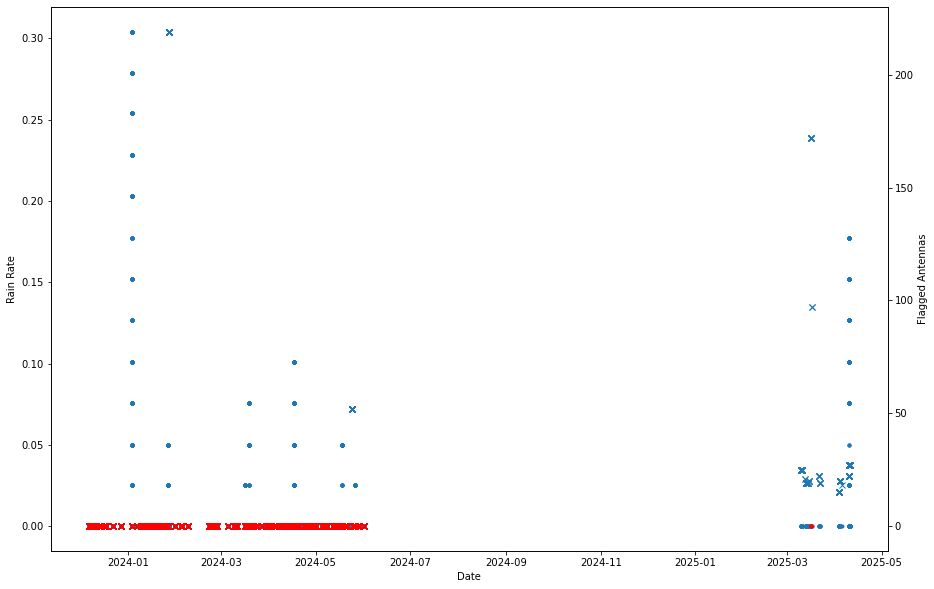

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
ax2 = ax.twinx()
fig.patch.set_facecolor("white")
ax.plot(plot_file_times, rain_rates, ".")
ax2.plot(plot_file_times, n_bad_ants, "x")
no_rain_data = np.where(~np.isfinite(rain_rates))[0]
ax.plot(plot_file_times[no_rain_data], np.zeros(len(no_rain_data)), ".", color="red")
no_ant_flag_data = np.where(~np.isfinite(n_bad_ants))[0]
ax2.plot(plot_file_times[no_ant_flag_data], np.zeros(len(no_ant_flag_data)), "x", color="red")
ax.set_ylabel("Rain Rate")
ax.set_xlabel("Date")
ax2.set_ylabel("Flagged Antennas")